# Module 3: Evaluatie

Je hebt in de vorige module gezien hoe je user ratings kunt voorspellen. We hebben twee verschillende aanpakken gezien: _user-based_ en _item-based_. We hebben verschillende _similarity-maten_ gezien: _cosine similarity_ en _euclidean similarity_. Wat hebben we hier nu aan? Welk algoritme werkt het beste?

Wat de beste aanpak is valt geen eenduidig antwoord op te geven. Dit hangt van een hoop verschillende factoren af. Wat voor een data hebben? Wat is het exacte doel van het recommender system? We kunnen wel gaan onderzoeken wat het beste werkt voor een specifieke dataset. En met een zeer specifiek doel. In deze module gaan we kijken welk algorithme de beste voorspellingen geeft voor de MovieLens dataset.

Wat je in de vorige module hebt gemaak is een algoritme om ratings mee te voorspellen. Dit is nog geen volledig recommender system. Dus we kunnen ook nog geen uitspraken doen over het resulterende recommender system. We kunnen echter wel iets zeggen over hoe goed de voorspellingen zijn. Om dat te doen gebruiken we hier weer de MovieLens dataset, maar dit keer gebruiken we een iets grotere subset.

### Offline testen met een test set:

Een veelgebruikte strategie is het opsplitsen van de data in een _training set_ en een _test set_. Op basis van de _training set_ leren we de overeenkomsten, waarmee we vervolgens voorspellingen kunnen doen voor de _test set_. Deze scheiding is belangrijk omdat zo de _test set_ onbekende data blijft, deze hebben we niet meegenomen in het leren van de overeenkomsten. Dus kunnen we testen of de voorspellingen op basis van de overeenkomsten uit de _training set_ ook werken voor nieuwe / onbekende data.

Hiervoor doorlopen we straks de volgende stappen:

* We splitsen de data vervolgens op in twee subsets: een _test set_ en een _training set_.
* Op basis van de _training set_ maken we een similarity matrix.
* Daaruit voorspellen we de ratings voor de film/user combinaties in de _test set_.
* Vervolgens vergelijken we de voorspelde ratings met de echte ratings uit de _test set_.

### Extra helper functies
We beginnen met het laden van de benodigde packages.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# course specific packages
import answers
from helpers import number_of_movies, number_of_users, number_of_ratings, rating_density, split_data

# import from previous module
from cf1 import pivot_ratings, fill_nan_mean, create_similarity_matrix_cosine,\
                mean_center_columns, select_neighborhood, weighted_mean, mean_center_rows

Als je bij de bovenstaande import een error krijgt kan het zijn dat je niet in CI conda environment zit. Kijk nog even naar de installatie-instructies wellicht heb je een stap overgeslagen.


In de vorige module heb je een aantal functies geschreven: `pivot_ratings`, `fill_nan_mean`, `create_similarity_matrix_cosine`, `mean_center_columns`, `select_neighborhood`, `weighted_mean` en `mean_center_rows`.

Deze functies heb je nu weer nodig. Maar ze zijn nu al gegeven in de `collaborative_filtering` package. Je hoeft ze dus niet van vorige week te kopiëren.

### Laad de data

Hieronder laden we een nieuwe dataset. Deze bevat ruim 3000 ratings. Om te kunnen testen hoe goed ons algoritme werkt splitsen we de data in twee delen: `ratings_t80_training` (de data waarmee we gaan voorspellen) en `ratings_t80_test` (de data waarmee we testen hoe goed de voorspelling is). 

De dataset heeft een dichtheid van ongeveer 80% (vandaar de uitgang `_t80`). Dat wil zeggen dat gemiddeld elke gebruiker 80% van de films van een rating heeft voorzien. Omdat we een deel van de ratings appart houden voor de test set, blijft daar in de training set maar 60% van over. Dat is trouwens heel veel, in de praktijk haal je dat meestal bij lange na niet. Dit is een subselectie van een veel grotere dataset waarvan de dichtheid ver onder de 1% ligt.

In [2]:
# Load the ratings_t80
ratings_t80 = pd.read_csv('./mini-movielens/ratings_t80.csv')
ratings_t80_training, ratings_t80_test = split_data(ratings_t80)

# Show the stats
print('Stats training set:')
print(f'Number of ratings: {number_of_ratings(ratings_t80_training)}')
print(f'Number of users: {number_of_users(ratings_t80_training)}')
print(f'Number of movies: {number_of_movies(ratings_t80_training)}')
print(f'Density: {rating_density(ratings_t80_training)}')

# Display the first 5 rows of the data
display(ratings_t80.head())

Stats training set:
Number of ratings: 3006
Number of users: 25
Number of movies: 200
Density: 0.6012


,userId,movieId,rating,timestamp
0,68,1,2.5,1158531426
1,68,2,2.5,1158532776
2,68,16,3.5,1158533018
3,68,47,4.0,1158531489
4,68,50,3.0,1158531764


### Vraag 1
Maak een utility matrix in een variabele genaamd `utility` en een _adjusted cosine_ similarity matrix in een variabele genaamd `similarity`. Doe beide voor _item based_ filtering. Gebruik hiervoor de functies die je in deel 1 van de opdracht hebt gemaakt.

In [3]:
# TODO

def cosine_temp_distance(series1, series2):
    """ Compute manhattan distance between two datapoints. """     
    # compute the distances for the features
    distances = series1 * series2
    a1 = series1**2
    b1 = series2**2
    
    # return the absolute sum
    return distances.sum()/(np.sqrt(a1.sum())*np.sqrt(b1.sum()))

def cosine_temp_similarity(matrix, id1, id2):
    """ Compute manhattan similarity between two datapoints. Can return a nan-value when there are no shared features. """
    # compute distance
    matrix = matrix.replace(np.nan,0.0)
    distance = cosine_temp_distance(matrix.loc[id1], matrix.loc[id2])
    # else return similarity
    return distance


def create_similarity_matrix_cosine_temp(matrix):
    
    gem = matrix
    meanmatrix = matrix.mean(axis = 0)
    meanmatrix = np.array(meanmatrix)
    for i in range(len(gem)):
        for j in range(len(gem.columns)):
             gem.iloc[i,j]=  gem.iloc[i,j] - meanmatrix[j]

    similarity_matrix = pd.DataFrame(data=0, index=gem.index, columns=gem.index, dtype=float)
    for i in range(len(gem)):
        for j in range(len(gem)):
           similarity_matrix.iloc[i,j] = cosine_temp_similarity(gem, similarity_matrix.columns[i] , similarity_matrix.columns[j])

    return similarity_matrix


def pivot_ratings(ratings):
    """ takes a rating table as input and computes the utility matrix """
    user = sorted(list(set(ratings['userId'])))
    movies = sorted(list(set(ratings['movieId'])))
# Create empty pivot table
    pivot = np.empty((len(movies), len(user)))
    pivot[:] = np.nan
    ratings = ratings.reset_index(drop=True)
# Fill in pivot table with ratings
    for i in range(len(ratings)):
        user_index = user.index(ratings['userId'][i])
        movie_index = movies.index(ratings['movieId'][i])
        pivot[movie_index, user_index] = ratings['rating'][i]
        
   
# Convert pivot table to a DataFrame
    pivot_df = pd.DataFrame(pivot, index=movies, columns=user)
    return pivot_df


def fill_nan_mean(matrix):
    # get the mean for each row
    meanv = matrix.mean(axis = 1, skipna=True)
    
    # fill all nan values with mean 
    # (fillna only works for collumns, so the matrix is transposed twice)
    filled1 = matrix.T.fillna(meanv).T
    
    # if there's still nan's left, it means the entire row is nan, so
    # no mean could be computed. fill with 0 in that case
    filled2 = filled1.fillna(0)
    return filled2
    


utility = pivot_ratings(ratings_t80_training)

utility_matrix_filled = fill_nan_mean(utility)


similarity = create_similarity_matrix_cosine_temp(utility_matrix_filled)

utility = pivot_ratings(ratings_t80_training)
display(utility.head())
display(similarity.head())

,68,105,177,182,232,249,274,288,298,307,...,474,480,483,590,599,600,603,606,608,610
1,2.5,NaN,NaN,4.0,NaN,4.0,4.0,4.5,2.0,4.0,...,4.0,NaN,NaN,4.0,3.0,2.5,4.0,2.5,NaN,NaN
2,NaN,NaN,3.5,NaN,4.0,4.0,3.5,2.0,0.5,2.5,...,3.0,3.0,4.0,2.5,NaN,4.0,NaN,NaN,2.0,NaN
16,3.5,4.5,NaN,5.0,NaN,NaN,4.5,NaN,NaN,NaN,...,4.0,4.0,4.0,NaN,3.0,NaN,4.0,NaN,4.5,4.5
32,NaN,3.5,NaN,4.0,NaN,5.0,4.0,NaN,4.0,3.5,...,4.0,4.0,5.0,3.0,3.0,NaN,3.0,4.0,NaN,4.5
47,NaN,5.0,4.5,NaN,4.5,5.0,4.0,NaN,4.0,4.0,...,NaN,4.5,3.5,3.0,4.0,4.0,NaN,3.0,4.5,5.0


,1,2,16,32,47,50,104,110,153,223,...,46578,48385,48394,48516,48780,51662,52722,53125,58559,59315
1,1.000000,0.168743,-0.020040,-0.096972,-0.022351,0.151485,-0.230859,0.121628,-0.022195,0.176785,...,-0.032943,0.282065,-0.139659,0.099080,0.217189,-0.099192,0.075603,-0.160189,-0.103409,0.044789
2,0.168743,1.000000,-0.482041,-0.204514,-0.463949,-0.436061,0.372800,0.186018,0.613228,-0.023415,...,-0.126030,0.096443,-0.154763,-0.407525,0.106556,-0.039754,0.462021,0.510987,-0.521303,-0.317854
16,-0.020040,-0.482041,1.000000,0.113875,0.489484,0.644972,-0.309973,-0.099919,-0.418123,-0.068501,...,0.313134,0.286079,0.062617,0.555116,0.158434,0.245228,-0.407579,-0.170303,0.492128,0.330839
32,-0.096972,-0.204514,0.113875,1.000000,0.442989,0.328448,-0.506858,0.119328,-0.497107,-0.034309,...,0.343029,-0.072641,0.510843,0.297535,0.422813,0.165825,-0.581471,-0.387422,0.506793,0.570990
47,-0.022351,-0.463949,0.489484,0.442989,1.000000,0.349315,-0.595072,-0.168127,-0.666247,-0.332830,...,0.094299,-0.006233,0.153809,0.700517,0.393713,0.249888,-0.547349,-0.159551,0.628873,0.488278


In [4]:
answers.test_1(utility, similarity)

Check utility: success!
Check similarity: success!


### Efficiënt werken
Om efficiënt om te gaan met computationele tijd, is het handig om je berekeningen soms tussendoor op te slaan, zodat je ze niet elke keer opnieuw hoeft te doen. Het kan best wat rekentijd kosten om een similarity matrix op te bouwen, zeker als je computer wat ouder is of als je een nog veel grotere dataset hebt dan die hierboven gegeven. 

Het uitrekenen kunnen we daarom beter 1x doen, even opslaan en vervolgens kunnen we dit weer inladen. Om dit te doen gebruikt `pandas` het dataformaat Pickle: dit kan in weinig bytes veel informatie kwijt en kan snel weer ingeladen worden. 

In de code hieronder slaan we de matrices op als een pickle-bestand (`.pkl`), en laden we deze vervolgens weer in om even te laten zien hoe dat werkt.

In [5]:
utility.to_pickle('./mini-movielens/ratings_t80_utility_student.pkl')
similarity.to_pickle('./mini-movielens/ratings_t80_similarity_student.pkl')

u = pd.read_pickle('./mini-movielens/ratings_t80_utility_student.pkl')
s = pd.read_pickle('./mini-movielens/ratings_t80_similarity_student.pkl')

pd.testing.assert_frame_equal(u, utility)
pd.testing.assert_frame_equal(s, similarity)

### Voorberekende data
In de rest van de opgave maken we gebruik van een aantal verschillende datasets. Om het laden wat te versnellen en om er zeker van te zijn dat iedereen met dezelfde data rekent hebben we vast de data gesplitst en de utility en de (adjusted cosine) similarity matrix uitgerekend. Met de onderstaande code kan je deze data laden.

In [6]:
ratings = pd.read_csv(f'./mini-movielens/ratings_t80.csv')[['userId', 'movieId', 'rating', 'timestamp']]

training_data = pd.read_pickle(f'./mini-movielens/ratings_t80_training.pkl')
test_data = pd.read_pickle(f'./mini-movielens/ratings_t80_test.pkl')
utility_items = pd.read_pickle(f'./mini-movielens/ratings_t80_utility_items.pkl')
similarity_items = pd.read_pickle(f'./mini-movielens/ratings_t80_similarity_items.pkl')

display(utility_items.head())
display(similarity_items.head())

print(ratings.shape, training_data.shape, test_data.shape, utility_items.shape, similarity_items.shape)

userId,68,105,177,182,232,249,274,288,298,307,...,474,480,483,590,599,600,603,606,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,NaN,NaN,4.0,NaN,4.0,4.0,4.5,2.0,4.0,...,4.0,NaN,NaN,4.0,3.0,2.5,4.0,2.5,NaN,NaN
2,NaN,NaN,3.5,NaN,4.0,4.0,3.5,2.0,0.5,2.5,...,3.0,3.0,4.0,2.5,NaN,4.0,NaN,NaN,2.0,NaN
16,3.5,4.5,NaN,5.0,NaN,NaN,4.5,NaN,NaN,NaN,...,4.0,4.0,4.0,NaN,3.0,NaN,4.0,NaN,4.5,4.5
32,NaN,3.5,NaN,4.0,NaN,5.0,4.0,NaN,4.0,3.5,...,4.0,4.0,5.0,3.0,3.0,NaN,3.0,4.0,NaN,4.5
47,NaN,5.0,4.5,NaN,4.5,5.0,4.0,NaN,4.0,4.0,...,NaN,4.5,3.5,3.0,4.0,4.0,NaN,3.0,4.5,5.0


movieId,1,2,16,32,47,50,104,110,153,223,...,46578,48385,48394,48516,48780,51662,52722,53125,58559,59315
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.074719,0.006048,-0.123256,-0.052228,0.177143,-0.611335,0.078965,-0.368889,0.172374,...,-0.189154,0.358179,-0.258308,0.553921,0.431211,-0.331644,0.269666,-0.304307,-0.021524,0.351863
2,-0.074719,1.000000,-0.229868,-0.297085,-0.434521,-0.570727,0.176152,-0.170048,0.699054,-0.264236,...,-0.068210,0.103298,0.504474,-0.396351,0.563123,-0.172086,0.136263,0.495172,-0.285229,-0.143689
16,0.006048,-0.229868,1.000000,-0.227995,0.547404,0.708517,-0.140028,-0.071521,0.147167,-0.081598,...,-0.030113,0.191778,-0.429182,0.712472,-0.205609,0.671984,0.455058,0.489067,0.255038,-0.264911
32,-0.123256,-0.297085,-0.227995,1.000000,0.276384,0.337146,-0.433426,0.381141,-0.268527,0.731417,...,0.712671,0.047492,0.821246,-0.036044,0.145748,0.407662,-0.755221,-0.282205,0.521183,0.482450
47,-0.052228,-0.434521,0.547404,0.276384,1.000000,0.272674,-0.714514,0.065212,-0.695938,-0.224932,...,0.178282,0.297428,-0.251417,0.716111,0.147248,0.187771,-0.346008,0.142365,0.577807,0.322909


(3999, 4) (3006, 4) (993, 4) (200, 25) (200, 200)


### Vraag 2

Schrijf hieronder een functie die voor elke rating in de _test data_ een rating voorspelt. Gebruik hiervoor dezelfde _item based_ aanpak als in de vorige opdracht. (Gebruik voor de neighborhood k = 100).

De input van de functie is de similarity matrix, de utility matrix en de test data. De output is hetzelfde als de test data, alleen is de kolom met ratings vervangen met voorspelde ratings. De bedoeling is dat de output er zo uitziet als hieronder: 

<table border="1" class="dataframe">
    <thead>
        <tr style="text-align: right;">
            <th></th>
            <th>userId</th>
            <th>movieId</th>
            <th>predicted rating</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>1</th>
            <td>68</td>
            <td>2</td>
            <td>3.487983</td>
        </tr>
        <tr>
            <th>3</th>
            <td>68</td>
            <td>47</td>
            <td>3.457851</td>
        </tr>
        <tr>
            <th>6</th>
            <td>68</td>
            <td>110</td>
            <td>3.625071</td>
        </tr>
        <tr>
            <th>14</th>
            <td>68</td>
            <td>344</td>
            <td>3.457997</td>
        </tr>
        <tr>
            <th>27</th>
            <td>68</td>
            <td>593</td>
            <td>3.494299</td>
        </tr>
        <tr>
            <th style="text-align: center;" colspan=5>...</th>
        </tr>
    </tbody>
</table>

In [7]:
def select_neighborhood(similarities, ratings, k):
    """ selects the k items all items with similarity > 0  """
    
    # Filter out items with a similarity score of 0 or less
    rslt_df = similarities[similarities > 0]
    if len(rslt_df) == 1:
        return rslt_df
        
    elif(len(rslt_df) > 1):
        rslt_df = rslt_df[rslt_df<1]
        return rslt_df[:k,]
    
    elif(rslt_df.empty == True):
        return rslt_df

def weighted_mean(neighborhood, ratings):  
    k =  neighborhood*ratings
    ratingInNeighbourHood = (ratings/ratings) *neighborhood
    ratingInNeighbourHood = ratingInNeighbourHood.dropna() 
    k = k.dropna() 
    if k.empty == True:
        return np.nan
    
    else:
        return k.sum()/ratingInNeighbourHood.sum()
    
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    display(user_item_pairs)
    ratings_test_c = user_item_pairs.copy()
    pred_rating = []
    movie_id = ratings_test_c["movieId"].reset_index(drop=True)
    user_id = ratings_test_c["userId"].reset_index(drop=True)
    rating = ratings_test_c["rating"].reset_index(drop=True)
    for i in range(len(movie_id)):
        neighborhood = select_neighborhood(similarity[movie_id[i]], utility[user_id[i]], 100)
        pred_rating.append(weighted_mean(neighborhood, utility[user_id[i]]))
    ratings_test_c["predicted rating"] = pred_rating
    return ratings_test_c.loc[:, ratings_test_c.columns != "rating"]
    # TODO
    

actual = test_data[['userId', 'movieId', 'rating']]
    
predicted_item_based = predict_ratings_item_based(similarity_items, utility_items, actual)
display(predicted_item_based.head())

,userId,movieId,rating
1,68,2,2.5
3,68,47,4.0
6,68,110,2.5
14,68,344,2.5
27,68,593,3.5
...,...,...,...
3971,610,7361,5.0
3976,610,8874,5.0
3986,610,44191,3.5
3994,610,51662,4.0


,userId,movieId,predicted rating
1,68,2,3.487983
3,68,47,3.394404
6,68,110,3.625071
14,68,344,3.457997
27,68,593,3.498636


In [8]:
answers.test_2(predict_ratings_item_based, similarity_items, utility_items, test_data)

Computing solution: 

,userId,movieId,rating
1,68,2,2.5
3,68,47,4.0
6,68,110,2.5
14,68,344,2.5
27,68,593,3.5
...,...,...,...
3971,610,7361,5.0
3976,610,8874,5.0
3986,610,44191,3.5
3994,610,51662,4.0


success!
Testing layout of prediction: success!
Testing values of prediction: success!


### Mean squared error

Hoe meten we nu hoe goed de voorspelling is? De manier waarop we dit doen lijkt een beetje op bepalen van *similarity* tussen films of gebruikers. We bepalen eerst de afwijking (de *error*) per voorspelde rating:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th>user</th><th>movie</th><th>:</th><th>actual<br>rating</th><th>-</th><th>predicted<br>rating</th><th>=</th><th>difference</th></tr></thead><tbody>
    <tr><td>68</td><td>2</td><td></td><td>2.5</td><td>-</td><td>3.487983</td><td>=</td><td>-0.99</td></tr>
    <tr><td>68</td><td>47</td><td></td><td>4.0</td><td>-</td><td>3.457851</td><td>=</td><td>0.54</td></tr>
    <tr><td>68</td><td>110</td><td></td><td>2.5</td><td>-</td><td>3.625071</td><td>=</td><td>-1.13</td></tr>
    <tr><td>68</td><td>344</td><td></td><td>2.5</td><td>-</td><td>3.457997</td><td>=</td><td>-0.96</td></tr>
    <tr><td>68</td><td>593</td><td></td><td>3.5</td><td>-</td><td>3.494299</td><td>=</td><td>0.01</td></tr>
    <tr><th  style="text-align: center;" colspan=8>...</th></tr></tbody></table>
    
Dan nemen we het gemiddelde van de kwadraten van de afwijkingen:

$$
\textrm{mean square error} = \frac{(-0.99)^2 + 0.54^2 + (-1.13)^2 + (-0.96)^2 + 0.01^2 + \ldots}{N}
$$

Waarbij $N$ het aantal items in de test set is. Deze maat voor de afwijking wordt de **mean squared error** (mse) genoemd. Dit is een zeer veel gebruikte maat in data science en machine learning, je zal hem in de toekomst nog vaak tegenkomen. 

De formele definitie voor de liefhebber:

$$
\textrm{mse} = \frac{1}{N}\sum_{i=1}^N(a_i - p_i)^2
$$

waarbij $a_i$ de echte rating en $p_i$ de voorspelde rating voor sample $i$.


### Vraag 3

Implementeer de functie `mse()` hieronder:

In [9]:
def mse(actual, predicted):
    return (1/len(actual))*sum((actual["rating"]-predicted["predicted rating"])**2)

mse_item_based = mse(actual, predicted_item_based)
print(mse_item_based)

0.5985023628895497


In [10]:
answers.test_3(mse, actual, predicted_item_based)

Testing mse item based: success!


### Wat betekent dit?

Als het goed is komt er een getal rond de 0.6 uit de mean squared error voor de voorspellingen voor deze specifieke dataset. Is dat goed? Het probleem met _mse_ is dat de waarde op zichzelf niet zoveel zegt. Het is vooral nuttig om uitkomsten met elkaar te kunnen vergelijken. We kunnen bijvoorbeeld kijken hoe goed _item based filtering_ het doet ten opzichte van _user based filtering_.

### Vraag 4

Implementeer hieronder de functie `predict_ratings_user_based()`. De output moet verglijkbaar zijn met de functie `predict_ratings_item_based()`:

<table border="1" class="dataframe">
    <thead>
        <tr style="text-align: right;">
            <th></th>
            <th>userId</th>
            <th>movieId</th>
            <th>predicted rating</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>1</th>
            <td>68</td>
            <td>2</td>
            <td>3.315977</td>
        </tr>
        <tr>
            <th>3</th>
            <td>68</td>
            <td>47</td>
            <td>4.503289</td>
        </tr>
        <tr>
            <th>6</th>
            <td>68</td>
            <td>110</td>
            <td>3.829485</td>
        </tr>
        <tr>
            <th>14</th>
            <td>68</td>
            <td>344</td>
            <td>2.926228</td>
        </tr>
        <tr>
            <th style="text-align: center;" colspan=4>...</th>
        </tr>
    </tbody>
</table>

In [11]:
def predict_ratings_user_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    pred_rating = []
    movie_id = ratings_test_c["movieId"].reset_index(drop=True)
    user_id = ratings_test_c["userId"].reset_index(drop=True)
    rating = ratings_test_c["rating"].reset_index(drop=True)
    for i in range(len(movie_id)):
        neighborhood = select_neighborhood(similarity[user_id[i]], utility[movie_id[i]], 100)
        pred_rating.append(weighted_mean(neighborhood, utility[movie_id[i]]))
    ratings_test_c["predicted rating"] = pred_rating
    
    return ratings_test_c.loc[:, ratings_test_c.columns != "rating"]

    # TODO
    
    
test_data = pd.read_pickle(f'./mini-movielens/ratings_t80_test.pkl')
utility_users = pd.read_pickle(f'./mini-movielens/ratings_t80_utility_users.pkl')
similarity_users = pd.read_pickle(f'./mini-movielens/ratings_t80_similarity_users.pkl')

actual = test_data[['userId', 'movieId', 'rating']]

predicted_user_based = predict_ratings_user_based(similarity_users, utility_users, actual)
display(predicted_user_based.head())
mse_user_based = mse(actual, predicted_user_based)
print(mse_user_based)

,userId,movieId,predicted rating
1,68,2,3.315977
3,68,47,4.503289
6,68,110,3.829485
14,68,344,2.926228
27,68,593,4.323535


0.6632865685016696


In [12]:
answers.test_4(mse, actual, predicted_user_based, predicted_item_based)

Testing user based versus item based prediction: success!


### Beter dan random?

We hebben nu gezien dat item based filtering iets beter werkt dan user based, **voor deze data**. Maar dat geeft ons nog steeds geen duidelijk idee van hoe goed het is. 

We hebben nog steeds geen duidelijke baseline. Hoe hoog zou de _mse_ bijvoorbeeld uitpakken als we compleet willekeurige voorspellingen doen.

### Vraag 5

Genereer nu als voorspelling voor elke film een random rating tussen de `0.5` en `5.0`. Plaats deze in eenzelfde tabel als eerder, gebruik hiervoor de tabel `actual`. Bereken vervolgens de _mse_ voor deze voorspelling. Sla het resultaat op in de variabele `mse_random`.

In [13]:
mse_random = 0
import random
# Pas deze tabel aan voor met jouw random voorspellingen.
predicted_random = actual.copy()
rating = predicted_random["rating"].reset_index(drop=True)

rating_pred =[]
for i in range(len(rating)):
    x = random.uniform(0.5, 5.0)
    rating_pred.append(x)
    mse_random += (rating[i]-x)**2
    
mse_random =(1/len(rating))*mse_random
predicted_random["predicted rating"] = rating_pred
predicted_random = predicted_random.loc[:, predicted_random.columns != "rating"]
display(predicted_random)



# TODO

print(f'mse for item based prediction: {mse_item_based:.2f}')
print(f'mse for user based prediction: {mse_user_based:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')

,userId,movieId,predicted rating
1,68,2,2.045207
3,68,47,4.955298
6,68,110,4.079638
14,68,344,0.954900
27,68,593,3.422034
...,...,...,...
3971,610,7361,2.723612
3976,610,8874,2.616027
3986,610,44191,1.061615
3994,610,51662,3.313223


mse for item based prediction: 0.60
mse for user based prediction: 0.66
mse for random prediction: 3.50


In [14]:
answers.test_5(mse_random)

Testing: success!


### Beter dan het gemiddelde per film?

Het is altijd goed om meerdere baselines te bekijken. We zouden ook kunnen kijken hoe goed het werkt om altijd de gemiddelde rating van een film te gebruiken als voorspelling. 

### Vraag 6

Voeg aan de series `predicted_item_mean` hieronder de kolom `predicted rating` toe. Genereer als voorspelling voor elke film de gemiddelde rating per film van de _training set_. Kijk nog even in de vorige module als je vergeten bent hoe je dit kan doen. Je kan hiervoor handig de methodes `groupby()` en `aggregate()` en de functie `np.mean()` gebruiken. Gebruik deze gemiddelde rating als voorspelling van de _test set_. Hiervoor is de methode `join()` heel handig. Bereken vervolgens de _mse_ over deze voorspelling. Bewaar de uitkomst in de variable `mse_item_mean`.

In [15]:
mse_item_mean = 0
predicted_item_mean = actual.copy()
item_mean= predicted_item_mean.groupby('movieId').agg({'rating': np.mean})
item_mean["predicted rating"] = item_mean["rating"]

item_mean = item_mean.loc[:, item_mean.columns != "rating"]
predicted_item_mean =predicted_item_mean.join(item_mean, on= "movieId")

mse_item_mean = sum((predicted_item_mean["rating"] - predicted_item_mean["predicted rating"])**2)
    
mse_item_mean =(1/len(predicted_item_mean))*mse_item_mean
predicted_item_mean = predicted_item_mean.loc[:, predicted_item_mean.columns != "rating"]
# TODO

print(f'mse for item based prediction: {mse_item_based:.2f}')
print(f'mse for user based prediction: {mse_user_based:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')
print(f'mse for mean per item: {mse_item_mean:.2f}')

mse for item based prediction: 0.60
mse for user based prediction: 0.66
mse for random prediction: 3.50
mse for mean per item: 0.52


In [16]:
answers.test_6(mse_item_mean)

Testing: success!


### Verdeling

We hebben nu de mse van drie verschillende aanpakken vergeleken, maar hoe zijn de voorspellingen precies verdeeld? Dit is een goed moment om de voorspellingen te visualiseren met een aantal histogrammen. Run de onderstaande code: 

     | actual | mean | item | user
-----+--------+------+------+-----
mean |   3.66 | 3.66 | 3.69 | 3.72
std  |   0.90 | 0.55 | 0.41 | 0.49


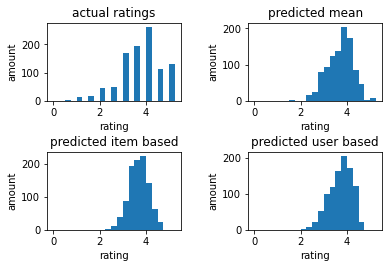

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.tight_layout(pad=3.0)

axes = [ax1, ax2, ax3, ax4]
data = [actual['rating'], 
        predicted_item_mean['predicted rating'], 
        predicted_item_based['predicted rating'],
        predicted_user_based['predicted rating']]
titles = ["actual ratings", "predicted mean", "predicted item based", "predicted user based"]

for ax, d, title in zip(axes, data, titles):
    ax.hist(list(d), bins=list(np.arange(0,5.5,0.25)))
    ax.set_xlabel("rating")
    ax.set_ylabel("amount")
    ax.set_title(title)
 

print('     | actual | mean | item | user')
print('-----+--------+------+------+-----')
print(f'mean |   {data[0].mean():.2f} | {data[1].mean():.2f} | {data[2].mean():.2f} | {data[3].mean():.2f}')
print(f'std  |   {data[0].std():.2f} | {data[1].std():.2f} | {data[2].std():.2f} | {data[3].std():.2f}')

Je ziet dat de verdeling voorspelde ratings van alle drie de algoritmes (item based filtering, user based filtering en de mean baseline) er redelijk vergelijkbaar uitzien. Met een gemiddelde rond de 3.70 en standaarddeviatie van rond de 0.45. De daadwerkelijk rating daarentegen heeft een veel hogere standaarddeviatie (0.90). 

### Vraag 7

Probeer te beredeneren waarom de standaarddeviatie voor de voorspelde ratings lager is dan die van de daadwerlijke rating. Met ander woorden, waarom zijn zeer hoge en zeer lage voorspelde ratings relatief zeldzaam?

Zeer hoge en zeer lage ratings kan je zien als extreme waarde. Denk aan de normale verdeling waarbij we te maken hebben met een hoger kans dichtbij de mean en lager kans verder van de mean. In normale verdeling concentreren zich de meeste voorspellingen rond het gemiddelde van de voorspelde ratings.



Je hebt net gezien dat de *mse* van de baseline akelig dicht bij die van *user based collaborative filtering* komt. Het verschil is zelfs zo klein dat je je moet gaan afvragen of het nog wel significant is. Betekent dit dat user based filtering waardeloos is? 

Dat is moeilijk te zeggen, zelfs voor deze data. Een belangrijk vraag hierbij is: hoe betekenisvol is de maat *mse* zelf eigenlijk?

Om hier antwoord op te geven moeten we wat verder gaan kijken naar hoe het systeem uiteindelijk gebruikt wordt. Wat gebeurt er uiteindelijk in het systeem met de voorspelde rating? Wordt er een top 10 gegeven van items met de hoogste voorspelde rating? Worden er willekeurig 20 items aanbevolen waarvan de voorspelde rating hoger is dan 3.75? Kan de gebruiker invloed uitoefenen op de aanbevelingen? 

### Recommended items

We moeten dus wat concretere aannames doen over de werking van het recommender system: 
1. Voor elke gebruiker maken we een lijst met recommended items. Dat zijn films waarvoor de voorspelde rating hoger is dan of gelijk is aan een bepaalde drempelwaarde (bijvoorbeeld 3.75). 
2. En we maken een lijst met hidden items. Dit zijn films met een voorspelde rating die lager is dan de drempelwaarde, en die we dus niet willen aanbevelen. 
3. Vervolgens presenteren we de gebruiker met een lijst van $N$ willekeurige films uit de lijst van recommended items. (Deze aanname gaan we niet verder uitwerken in deze module, maar het is belangrijk om te weten dat alle recommended items een even grote kans hebben om aan de gebruiker getoond te worden.)

> Hiermee maken we van onze recommender system een classificatieprobleem: We hebben twee *classes*, recommended en hidden, en we willen van elk film/user paar weten in welke van de twee classes dit paar valt. Dit is een type probleem dat je bij machine learning vaak zal tegenkomen.

### Vraag 8

Implementeer hieronder de functies `recommended()` en `hidden()`. Deze functies krijgen als input een DataFrame met de voorspelde ratings en een drempelwaarde (`treshold`). De output is een Dataframe met alle relevante combinaties van `userId` en `movieId`. 

In [18]:
def recommended(predictions, treshold):
    # TODOi
    predictions = predictions[predictions['predicted rating'] >= treshold]
    return predictions.loc[:, predictions.columns != 'predicted rating']



def hidden(predictions, treshold):
    # TODO
    predictions = predictions[predictions['predicted rating'] < treshold]
    return predictions.loc[:, predictions.columns != 'predicted rating']

    
treshold_recommended = 3.75219
recommended_items = recommended(predicted_item_based, treshold_recommended)
hidden_items = hidden(predicted_item_based, treshold_recommended)

print(f'Test items : {predicted_item_based.shape[0]}')
print(f'Recommended: {recommended_items.shape[0]}')
print(f'Hidden     : {hidden_items.shape[0]}')
display(recommended_items.head())
display(hidden_items.head())

Test items : 993
Recommended: 448
Hidden     : 545


,userId,movieId
195,105,50
207,105,750
210,105,912
217,105,1206
218,105,1208


,userId,movieId
1,68,2
3,68,47
6,68,110
14,68,344
27,68,593


In [19]:
answers.test_8(recommended, hidden, predicted_item_based, treshold_recommended)

Testing: success!


We weten nu voor elke gebruiker in de test set welke items aangeraden kunnen worden door het recommender systeem. Zijn die aanbevelingen terecht? Hiervoor kunnen we kijken naar de daadwerkelijke rating die gebruikers hebben gegeven. De aanname is dat als de gebruiker een hoge rating heeft gegeven dat de aanbevling dan terecht was. 

We noemen de items met een hoge aanbeveling *used* en items met een te lage aanbeveling *unused*. Ook hiervoor kunnen we weer een drempelwaarde voor gebruiken. Deze hoeft niet dezelfde te zijn als de drempelwaarde die recommended en hidden items van elkaar scheidt.

### Vraag 9

Implementeer hieronder de functies `used()` en `unused()`. Deze functies krijgen als input een DataFrame met de daadwerkelijke ratings en een drempelwaarde (`treshold`). De output is een Dataframe met alle relevante combinaties van `userId` en `movieId`. 

In [20]:
def used(actual, treshold):
    # TODO
    actual = actual[actual['rating']>= treshold]
    return actual.loc[:, actual.columns != 'rating']
    

def unused(actual, treshold):
    # TODO
    actual = actual[actual['rating']< treshold]
    return actual.loc[:, actual.columns != 'rating']
    
treshold_used = 4.0

used_items = used(actual, treshold_used)
unused_items = unused(actual, treshold_used)

print(f'Test items: {predicted_item_based.shape[0]}')
print(f'Used      : {used_items.shape[0]}')
print(f'Unused    : {unused_items.shape[0]}')
display(used_items.head())
display(unused_items.head())

Test items: 993
Used      : 503
Unused    : 490


,userId,movieId
3,68,47
28,68,595
33,68,912
46,68,1197
63,68,1291


,userId,movieId
1,68,2
6,68,110
14,68,344
27,68,593
39,68,1073


In [21]:
answers.test_9(used, unused, actual, treshold_used)

Testing: success!


We hebben een hoop aannames moeten doen over de werking van het recommender system en de interpretatie van de resultaten. Maar nu hebben we iets meer gereedschappen om mee te evalueren.

We kunnen bij voorbeeld eerst eens kijken naar het aantal items dat ook daadwerkelijk terecht aabevolen is. Dat is namelijk het aantal items dat zowel in de lijst `recommended_items` als `used_items` zit. Dit noemen we de *true positives*. Gegeven de vier lijsten (recommended, hidden, used en unused), kunnen we de volgende waardes bepalen:

* **true positives**: het aantal items die zowel in de lijst van *recommended items* als *used items* voorkomen.
* **false positives**: het aantal items die zowel in de lijst van *recommended items* als *unused items* voorkomen.
* **true negatives**: het aantal items die zowel in de lijst van *hidden items* als *unused items* voorkomen.
* **false negatives**: het aantal items die zowel in de lijst van *hidden items* als *used items* voorkomen.

Deze vier waardes worden meestal weergegeven in de vorm van een [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

### Opdracht 10

Implementeer hieronder de functie 'confusion()' met als input de vier lijsten (*recommended*, *hidden*, *used* en *unused*) en als output een 2x2 DataFrame met de confusion matrix.

In [22]:
def confusion(recommended, hidden, used, unused):
    TP = len(pd.merge(recommended, used, on=['movieId', 'userId']))
    FP = len(pd.merge(recommended, unused, on=['movieId', 'userId']))
    TN = len(pd.merge(hidden, unused, on=['movieId', 'userId']))
    FN =len(pd.merge(hidden, used, on=['movieId', 'userId']))
    confusion_matrix = pd.DataFrame([[TP, FP], [FN, TN]], columns=['used', 'unused'], index=['recommended', 'hidden'])
    return confusion_matrix
    

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,315,133
hidden,188,357


In [23]:
answers.test_10(confusion_matrix)

Testing: 

AssertionError: DataFrame.iloc[:, 0] (column name="used") are different

DataFrame.iloc[:, 0] (column name="used") values are different (100.0 %)
[index]: [recommended, hidden]
[left]:  [315, 188]
[right]: [314, 189]

### Precision

Een veelgebruikte maat voor evaluatie is **precision**. Precision is een maat voor de vraag: hoe vaak is een aanbevolen film ook terecht aanbevolen? 

Definitie:

$$
\textrm{precision} = \frac{\textrm{true positives}}{\textrm{#recommended items}} = \frac{\textrm{true positives}}{\textrm{true positives + false positives}}
$$

Dus, als alle films die worden aangeraden ook terecht zijn (i.e. $\textrm{false positives} = 0$), dan geldt:

$\textrm{precision} = 1$. 

Als geen van de films die worden aangeraden terecht zijn (i.e. $\textrm{true positives} = 0$) , dan geldt:

$\textrm{precision} = 0$. 

> Kijk voor meer informatie ook hier: https://en.wikipedia.org/wiki/Precision_and_recall

### Vraag 11

Implementeer de functie `precision()` hieronder, met als input de confusion matrix en als output de *precision*.

In [ ]:
def precision(confusion_matrix):
    TP = confusion_matrix.iloc[0, 0]
    FP = confusion_matrix.iloc[0, 1]
    
    return TP / (TP + FP)
    # TODO
    

precision_item_based = precision(confusion_matrix)

print(f'precision for item based prediction: {precision_item_based:.2f}')

In [ ]:
answers.test_11(precision_item_based)

### Recall

Precision zegt iets over hoe goed het algoritme werkt, maar zeker niet alles. Er zijn nog vele andere maten die relevant zijn voor de evaluatie van een algoritme. Een maat die veel in combinatie met precision wordt gebruikt is *recall*.

De centrale vraag bij **recall** is: hoe vaak worden items waarvan je zou willen dat ze aangeraden worden ook daadwerkelijk aangeraden door het algoritme? Met andere woorden als een gebruiker een film goed zou vinden, krijgt hij hem dan ook vaak aangeraden?

Definitie:

$$
\textrm{recall} = \frac{\textrm{true positives}}{\textrm{#used items}} = \frac{\textrm{true positives}}{\textrm{true positives + false negatives}}
$$

Dus, als we geen false negatives hebben (m.a.w. als alle films die de gebruike goed zou vinden ook daadwerkelijk worden aanbevolen), dan geldt: $\textrm{precision} = 1$.

### Vraag 12

Implementeer de functie `recall()` hieronder, met als input de confusion matrix en als output de *recall*.

In [ ]:
def recall(confusion_matrix):
    TP = confusion_matrix.iloc[0, 0]
    FN = confusion_matrix.iloc[1, 0]
    
    return TP / (TP + FN)
    # TODO
    
    

recall_item_based = recall(confusion_matrix)

print(f'recall for item based prediction: {recall_item_based:.2f}')

In [ ]:
answers.test_12(recall_item_based)

### Vraag 13

Nu kunnen we eindelijk de verschillende aanpakken met elkaar vergelijken. Bereken hieronder de *precision* en *recall* voor:
* item base collaborative filtering
* user based collaborative filtering
* random baseline
* mean baseline.

In [ ]:
treshold_recommended = 3.75
treshold_used = 4.0
used_items = used(actual, treshold_used)
unused_items = unused(actual, treshold_used)


recommendeduser = recommended(predicted_user_based, treshold_recommended)
hiddeduser = hidden(predicted_user_based, treshold_recommended)
confusionuser = confusion(recommendeduser, hiddeduser, used_items, unused_items)
precision_user_based = precision(confusionuser)
recall_user_based = recall(confusionuser)

recommendedrand = recommended(predicted_random, treshold_recommended)
hiddedrand = hidden(predicted_random, treshold_recommended)
confusionrand = confusion(recommendedrand, hiddedrand, used_items, unused_items)
precision_random = precision(confusionrand)
recall_random = recall(confusionrand)

recommendedmean = recommended(predicted_item_mean, treshold_recommended)
hiddedmean = hidden(predicted_item_mean, treshold_recommended)
confusionmean = confusion(recommendedmean, hiddedmean, used_items, unused_items)
precision_item_mean = precision(confusionmean)
recall_item_mean = recall(confusionmean)

# TODO


print('           | precision | recall')
print(f'item based |      {precision_item_based:.2f} |   {recall_item_based:.2f}')
print(f'user based |      {precision_user_based:.2f} |   {recall_user_based:.2f}')
print(f'random     |      {precision_random:.2f} |   {recall_random:.2f}')
print(f'mean       |      {precision_item_mean:.2f} |   {recall_item_mean:.2f}')

Bij recall zien we voor het eerst dat item based filtering het niet zo goed doet. Zowel user based filtering als bij mean per item is de recall-score hoger. Kennelijk gebeurt het bij item based filtering best vaak dat een film die de gebruiker best zou willen zien niet wordt aangeraden. Alleen zelfs dat zegt nog niet zoveel. Het is, bijvoorbeeld, waarschijnlijk (maar niet noodzakelijk) dat als we de `treshold_recommended` iets lager kiezen dat de recall dan omhoog gaat, maar de precision naar beneden.

### Vraag 14

Waarom is dat waarschijnlijk?

Er is namelijk een trade-off tussen recall en precision.
Wanneer de treshold_recommended lager wordt gekozen, zullen meer items worden aanbevolen, wat de recall zal verhogen, omdat er meer relevante items worden aanbevolen.

### Precision-recall curve

De performance van het algoritme is dus afhankelijk van de parameter `treshold_recommended`. En zoals je wel vaker zal zien in hebben we bij de keuze van die parameter te maken met een trade-off tussen verschillende evaluatiematen. In dit geval is er sprake van een trade-off tussen *precision* en *recall*. In zo'n geval is het gebruikelijk om een precision-recall curve te plotten. Voer de onderstaande code uit om te zien hoe zo'n curve er uit kan zien.

In [ ]:
tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

# good fake algorithm
precisions = [0.4, 0.5, 0.8, 0.9, 0.95]
recalls = [1.0, 0.98, 0.85, 0.5, 0]
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, tresholds):
    plt.text(r, p, t)

# bad fake algorithm
precisions = [0.4, 0.45, 0.5, 0.6, 0.95]
recalls = [1.0, 0.7, 0.5, 0.3, 0]
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, tresholds):
    plt.text(r, p, t)

plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['good fake algorithm', 'bad fake algorithm'], loc = 'lower left')

In de plot hierboven zien we de waardes van zowel *precision* als *recall* voor verschillende waardes van de parameter `treshold_recommended` van twee _denkbeeldige_ algoritmes. In een ideaal geval zouden we de *threshold* zo willen kiezen dat zowel *precision* als *recall* de waarde 1 hebben. Alleen voor geen van beide algoritmes is er zo'n waarde voor de *threshold*. We zien echter wel dat het goede algoritme (*good fake algorithm*) er een stuk dichter in de buurt komt. Deze plot geeft dus een stuk volledigere informatie over de werking van een algoritme dan een enkele waarde voor *precision* en *recall*.

Welke waarde voor de threshold het best is hang deels af van de toepassing. Is *precision* of *recall* een belangrijkere maat? Is het erger om onterecht films aan te raden? Of is het erger om films te negeren die de gebruiker wel graag had willen zien?

We kunnen er in dit geval wel iets over zeggen zonder in te gaan op de specifieke toepassing: Voor het goede algoritme is een een duidelijk cut-off te zien. Als je de *threshold* lager dan 3.5 kiest dan keldert de precision. het is dus in dit geval duidelijk een goed idee om de *threshold* in ieder geval boven de 3.5 te zetten.


### Vraag 15

Maak hieronder eenzelfde plot, maar nu met echte data. Plot de *precision-recall curves* voor:
* item base collaborative filtering
* user based collaborative filtering
* random baseline
* mean baseline.

Geef de `treshold_used` een vaste waarde van 3.75, en gebruik voor de `treshold_ recommended` waardes van 2.5 (inclusief) tot 5.0 (exclusief) met stappen van 0.5.

In [ ]:
# TODO
treshold_used = 3.75
treshold_recommended = [2.5,3.0,3.5,4.0,4.5]

used_items = used(actual, treshold_used)
unused_items = unused(actual, treshold_used)

precisionItem = []
recallItem = []

precisionUser = []
recallUser = []

precisionRand = []
recallRand = []

precisionMean = []
recallMean = []

for i in range(len(treshold_recommended)):
    
    recommendeditem = recommended(predicted_item_based, treshold_recommended[i])
    hiddeditem = hidden(predicted_item_based, treshold_recommended[i])
    confusionitem = confusion(recommendeditem, hiddeditem, used_items, unused_items)
    precisionItem.append(precision(confusionitem))
    recallItem.append(recall(confusionitem))
    
    
    recommendeduser = recommended(predicted_user_based, treshold_recommended[i])
    hiddeduser = hidden(predicted_user_based, treshold_recommended[i])
    confusionuser = confusion(recommendeduser, hiddeduser, used_items, unused_items)
    precisionUser.append(precision(confusionuser))
    recallUser.append(recall(confusionuser))

    recommendedrand = recommended(predicted_random, treshold_recommended[i])
    hiddedrand = hidden(predicted_random, treshold_recommended[i])
    confusionrand = confusion(recommendedrand, hiddedrand, used_items, unused_items)
    precisionRand.append(precision(confusionrand))
    recallRand.append(recall(confusionrand))

    recommendedmean = recommended(predicted_item_mean, treshold_recommended[i])
    hiddedmean = hidden(predicted_item_mean, treshold_recommended[i])
    confusionmean = confusion(recommendedmean, hiddedmean, used_items, unused_items)
    precisionMean.append(precision(confusionmean))
    recallMean.append(recall(confusionmean))

plt.plot(recallItem, precisionItem)
for r, p, t in zip(recallItem, precisionItem, treshold_recommended):
    plt.text(r, p, t)
plt.plot(recallUser, precisionUser)
for r, p, t in zip(recallUser, precisionUser, treshold_recommended):
    plt.text(r, p, t)
plt.plot(recallRand, precisionRand)
for r, p, t in zip(recallRand, precisionRand, treshold_recommended):
    plt.text(r, p, t)
plt.plot(recallMean, precisionMean)
for r, p, t in zip(recallMean, precisionMean, treshold_recommended):
    plt.text(r, p, t)



plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(['itemBased', 'userBased', "random", "mean"], loc = 'lower left')

De verschillen zijn niet zo enorm als bij het nepvoorbeeld, maar als het goed is, is er wel een algoritme dat het zichtbaar beter doet voor deze data.

### Vraag 16

Het zal je misschien opvallen dat de precision bij deze data nooit lager dan ongeveer 0.5 wordt. Waar zou dat door kunnen komen? 

De dataset heeft een hoge mate van sparsity, wat betekent dat er veel items zijn die niet beoordeeld zijn door gebruikers. Hierdoor worden er minder aanbevelingen gedaan, wat kan leiden tot minder fout-positieve aanbevelingen en daardoor hogere precisie-scores.

Bij deze algoritmes is de *threshold* een duidelijk parameter waarmee je de *precision* en *recall* kan beinvloeden. Maar, er zijn natuurlijk vaak nog meer dan genoeg andere parameters die van invloed kunnen zijn op deze waardes (bijvoorbeeld de waarde van `k` bij het selecteren van de *neighborhood*). Je zou in principe voor elke parameter zo'n curve kunnen maken bij het ontwerpen van een recommender system. Dat gaan we nu niet doen.

We gaan nog naar één ander interessant effect kijken: de data zelf. Dit soort algoritmes zijn op z'n best zo goed als de data die je ze voert. In dit geval hebben we gewerkt met een zeer dichte dataset. Voor ongeveer 80% van de mogelijke gebruiker-film paren is er een rating. Dat is héél veel meer dan je meestal zal tegenkomen als je een recommender system gaat bouwen. Deze data is een subset van een véél grote dataset waarvan de dichtheid lager dan 1% is.

Voer de code hieronder uit om een nieuwe dataset te laden. Deze set heeft een dichtheid van ongeveer 50%. Dat is nog steeds bij lange na niet zo laag als de oorspronkelijke dataset, maar hiermee kunnen we al gaan kijken of de dichtheid een effect heeft op het algoritm.

In [ ]:
training_data = pd.read_pickle(f'./mini-movielens/ratings_t50_training.pkl')
test_data = pd.read_pickle(f'./mini-movielens/ratings_t50_test.pkl')
utility_items = pd.read_pickle(f'./mini-movielens/ratings_t50_utility_items.pkl')
similarity_items = pd.read_pickle(f'./mini-movielens/ratings_t50_similarity_items.pkl')
predicted_item_based_50 = predict_ratings_item_based(similarity_items, utility_items, test_data)
actual_50 = test_data[["userId", "movieId", "rating"]]

### Vraag 17

Maak *precision-recall curve* voor alléén item based filtering met de bovenstaande dataset. Plot in dezelfde grafiek ook de item based filtering curve voor de oude dataset nog een keer.

In [ ]:
treshold_used = 3.75
treshold_recommended = [2.5,3.0,3.5,4.0,4.5]

used_items = used(actual_50, treshold_used)
unused_items = unused(actual_50, treshold_used)

precisionItem = []
recallItem = []

for i in range(len(treshold_recommended)):
    
    recommendeditem = recommended(predicted_item_based_50, treshold_recommended[i])
    hiddeditem = hidden(predicted_item_based_50, treshold_recommended[i])
    confusionitem = confusion(recommendeditem, hiddeditem, used_items, unused_items)
    precisionItem.append(precision(confusionitem))
    recallItem.append(recall(confusionitem))
    
plt.plot(recallItem, precisionItem)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
for r, p, t in zip(recallItem, precisionItem, treshold_recommended):
    plt.text(r, p, t)
plt.xlabel('recall')
plt.ylabel('precision')

# TODO


### Vraag 18
Zou je een toepassing van een recommender system kunnen noemen waarvoor precision en recall géén relevante maten zijn?

een recommender system voor de inhoud van nieuwsartikelen, blogs of sociale media-inhoud.

### Vraag 19
Je hebt voor de parameter *threshold_recommended* een precision-recall curve gemaakt, dus we hebben nu een redelijk beeld van het effect van die parameter op de kwaliteit van de voorspellingen. Welke parameters zou je nog meer kunnen(/moeten) onderzoeken?


Je zou de similarity parameter kunnen onderzoeken

# Done

In het eerste deel heb je gezien hoe je *item based collaborative filtering* kan implementeren. Hiervoor heb je geleerd hoe je een *utility matrix* kan maken. Die utility matrix heb je gebruikt voor het maken van een *similarity matrix*. Hiervoor heb je verschillende similarity-maten uitgebprobeerd. Uiteindelijk heb je met de *cosine similarity* de rest van het algoritme uitgewerkt. Dit bestond uit het bepalen van een *neighborhood* en vervolgens het berekenen van een gewogen gemiddelde voor die neighborhood. In het tweede deel heb je gezien hoe je dezelfde technieken kan toepassen voor *user based* collaborative filtering. 

In het derde deel hebben we gekeken hoe we de geleerde algoritmes kunnen *evalueren*. Hierbij hebben we alleen gekeken naar *offline test* (dus alleen met de gegeven historische data). Om dit te doen, moeten we een hoop aannames doen over gebruikersgedrag. De enige manier om deze aannames te toetsen zou met online testen. Wij kunnen dat niet doen binnen deze cursus, maar dit is wel wat bedrijven zoals Facebook continu doen. 

Er valt nog heel veel meer te zeggen over het onderwerp van evaluatie. Dit is een onderwerp wat ook buiten het domein van recommender systems van belang is. Onder andere veel machine learning algoritmes worden op vergelijkbare manier getoetst. Voor meer informatie:

* [Wikipedia, Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* [Wikipedia, Recommender systems](https://en.wikipedia.org/wiki/Recommender_system#Performance_measures)
* [G. Shani, A. Gunawardana, *Evaluating recommendation systems*](https://www.researchgate.net/publication/226264572_Evaluating_Recommendation_Systems) (gratis te downloaden vanaf het UvA netwerk).
* [M. Ge, C Delgado-Battenfeld, Dietmar Jannach, *Beyond Accuracy: Evaluating Recommender Systems by Coverage and Serendipity*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.8494&rep=rep1&type=pdf)


### Volgende module

Bij de laatste opgave zagen we dat de dichtheid van de dataset een effect heeft op de werking van collaborative filtering. Als de dichtheid lager wordt, werkt collaborative filtering minder goed. In de volgende module gaan we zien hoe we content based filtering kunnen gebruiken om dit probleem op te lossen.

## Extra conceptvragen 
Deze vragen hoef je niet in te leveren, maar zijn handig om te oefenen voor het tentamen.

### Conceptvraag 1
We hebben een hoop aannames gedaan bij het testen van de bovenstaande algoritmes. Bijvoorbeeld, een daadwerkelijk rating hoger dan 4.0 betekent dat een film terecht is aangeraden.

- a. Noem ten minste nog twee aannames die we hebben gedaan bij het evalueren van de *collaboratve filtering* algoritmes.
- b. Doe een suggestie voor een online evaluatie of gebruikersstudie waarmee we kunnen testen of deze aannames terecht zijn.

### Conceptvraag 2:
De maten die we hierboven hebben behandeld worden heel veel gebruikt, maar zijn zeker niet de enige mogelijke maten. Er zijn nog talloze vragen die we kunnen stellen over het systeem waar de huidige maten geen antwoord op geven. Bijvoorbeeld:
- Hoe groot de kans is dat gebruikers nieuwe filmgenres ontdekken? 
- Voor een nieuwsmediasite: Hoe groot is de kans dat gebruikers in een filterbubbel terechtkomen?
- Hoe groot is de kans dat een minder populair item wordt aanbevolen?
- Hoe groot is de diversiteit van aanbevolen films.

Kan je zelf een nuttige maat verzinnen die hier nog niet is behandeld? Wat is de definitie? Op welke vraag geeft de maat een antwoord? Waarom is dat een nuttige vraag?
